# Multivariate n-lagged Random Forest  

From:  https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

Random Forest models leverage the value of many trained decision trees - making it an ensemble technique - to come up with an estimator that delivers the best balance between goodness of fit (low bias) and generalization (low variance).  In regression modelling this means averaging the output of the estimates, while in classification this means a "win by votes".  

Timeseries data can be processed to be modelled using supervised learning algotithms like Random Forest.  The data must be "lagged", that is, the model is prompted to predict a target at time t using information from time t-1 (or t-n if n lags are imposed).  And this can be done for an autoregression, where a target is predicted based only on past values of itself, or it can be done for a multivariate scenario where a target variable is predicted on past values of itself and past values for the feature variables that impact on the target.

Here is an overview of the steps carried out in this effort:
* The raw dataset must be lagged to the desired lag value, and the lagged versions of the variables must be collated for input
> For the multivariate exercise, a lag of 1 will first be attempted to get a successful execution, then 4, then perhaps 8.
* The variables are split into training and test datasets
* The RandomForest is configured and fit on training data
* Predicted values are generated as "one-step" walking forecast predictions on a model re-fit with the training dataset and the last-used test data point/row.  
* These one-step walking forecast predictions are compared to their actual observations for plotting and the calculation of mean absolute error (MAE).  This mirrors a set-up where models are updated real-time on observed data as it is available. (! I'd like to streamline which errors are used on the various model trials, or have a good reason to deviate in one framework or other)

### Stationarity   

In the eda notebooks, the data was found to be stationary by the Augmented Dickey-Fuller test.

It is generally agreed that the data need not be stationary for LSTM models, however, it is recommended to get an idea of the stationarity of your data anyway as it may inform decisions around the useful life of your model and when a refresh may be required.

https://datascience.stackexchange.com/questions/30362/checking-for-stationarity-in-lstm#:~:text=You%20may%20want%20to%20force,you%20a%20boost%20in%20performance.  

To check for stationarity in Python, consult the following:  
https://machinelearningmastery.com/time-series-data-stationary-python/  

Tests for stationarity, generally:  

"There are various statistical tests to check stationarity, including the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. The ADF test is a widely used test for checking the stationarity of a time series, and it checks for the presence of a unit root in the data."  (Analytics Vidhya)  

The below code is taken from:    

The intention is to later adapt the templated code for multivariate forecasting.

In [7]:
# forecast weekly dengue cases
import numpy as np
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

### Multivariate Random Forest Timeseries Model with lag 1

[[ 4.00000000e+00  1.22600000e-01  1.03725000e-01 ...  1.40128571e+01
   2.62857143e+00  5.00000000e+00]
 [ 5.00000000e+00  1.69900000e-01  1.42175000e-01 ...  1.53728571e+01
   2.37142857e+00  4.00000000e+00]
 [ 4.00000000e+00  3.22500000e-02  1.72966700e-01 ...  1.68485714e+01
   2.30000000e+00  3.00000000e+00]
 ...
 [ 3.00000000e+00 -3.80000000e-02 -1.68333300e-02 ...  1.46628571e+01
   2.71428571e+00  1.00000000e+00]
 [ 1.00000000e+00 -1.55200000e-01 -5.27500000e-02 ...  1.41842857e+01
   2.18571429e+00  3.00000000e+00]
 [ 3.00000000e+00  1.80000000e-03 -5.27500000e-02 ...  1.38585714e+01
   2.78571429e+00  5.00000000e+00]]
>expected=2.0, predicted=9.5
>expected=6.0, predicted=7.9
>expected=8.0, predicted=6.1
>expected=5.0, predicted=8.1
>expected=1.0, predicted=6.4
>expected=2.0, predicted=3.8
>expected=3.0, predicted=4.4
>expected=4.0, predicted=4.1
>expected=3.0, predicted=7.3
>expected=1.0, predicted=3.6
>expected=3.0, predicted=4.5
>expected=5.0, predicted=4.8
MAE: 2.653


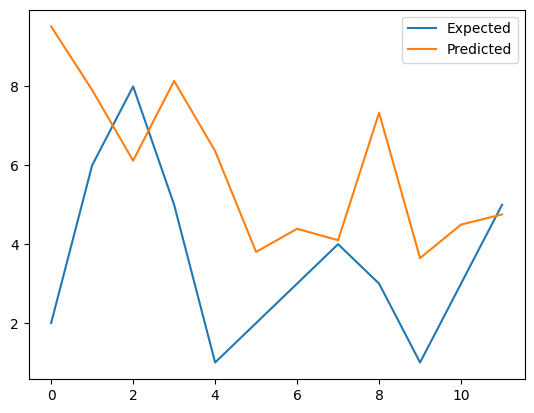

In [10]:
# convert series to supervised learning for multivariate scenarios
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# notice n_vars is now used to account for the columns in a multivariate dataset
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split dataset into train/test sets
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]	# added iloc hoping it'll fix the index error / briefly removed to see impact after fixing the column selection from series_to_supervised

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
#sj_df_cases = sj_df['total_cases'] # no longer univariate
values = sj_df.values
# transform the time series data into supervised learning
n_weeks = 1 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised(values, n_in=n_weeks) # one time lag for my univariate set-up; we'll try other lags on the multivariate set-up once it's running ok

# Select the proper columns from the output of series_to_supervised
# at 1 target and 14 features, you should get 15 columns lagged and 15 columns unlagged, for 30 columns in total.  We'd keep the lagged ones plus the unlagged target columns.  Will require careful handling:
n_obs = n_weeks * n_features
# grabs columns 0 to 14, the lagged output and inputs, and then only the 15th column from the end which is the unlagged output
# Select the relevant chunks of data
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  # no longer a "nice-looking" dataframe with column headers now, but a list of arrays, which likely works better in walk_forward_validation (and its functions)
print(data_recombined)				

# evaluate
mae, y, yhat = walk_forward_validation(data_recombined, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### Multivariate Random Forest Timeseries Model with lag 4

In [11]:
# convert series to supervised learning for multivariate scenarios
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# notice n_vars is now used to account for the columns in a multivariate dataset
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split dataset into train/test sets
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]	# added iloc hoping it'll fix the index error / briefly removed to see impact after fixing the column selection from series_to_supervised

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
#sj_df_cases = sj_df['total_cases'] # no longer univariate
values = sj_df.values
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised(values, n_in=n_weeks) # one time lag for my univariate set-up; we'll try other lags on the multivariate set-up once it's running ok

# Select the proper columns from the output of series_to_supervised
# at 1 target and 14 features, you should get 15 columns lagged and 15 columns unlagged, for 30 columns in total.  We'd keep the lagged ones plus the unlagged target columns.  Will require careful handling:
n_obs = n_weeks * n_features
# grabs columns 0 to 14, the lagged output and inputs, and then only the 15th column from the end which is the unlagged output
# Select the relevant chunks of data
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  # no longer a "nice-looking" dataframe with column headers now, but a list of arrays, which likely works better in walk_forward_validation (and its functions)
print(data_recombined)				

# evaluate
mae, y, yhat = walk_forward_validation(data_recombined, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

May yet see what I get from running  
```yhat = model.predict(testX)```  
Ensuring I feed it the correct input (testX).  See the rf_trial_nlags_UV.ipynb notebook to see how I did it there.